In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm.notebook import tqdm

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
from torchvision.utils import make_grid

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Seed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
SEED = 17
seed_everything(SEED)

# Data Folder

In [6]:
data_dir = '../input/cassava-leaf-disease-classification'
train_dir = data_dir + '/train_images'
train_csv = data_dir + '/train.csv'
test_dir = data_dir + '/test_images'
name_json = data_dir + '/label_num_to_disease_map.json'
sample_csv = data_dir + '/sample_submission.csv'

# Focal Loss

In [7]:
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

# Read CSV

In [8]:
train_df = pd.read_csv(train_csv)
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [9]:
train_df.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [10]:
train_df.label.value_counts() / len(train_df)

3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64

In [11]:
cutoff = 1087

the dataset seems heavily unbalanced towards label 3.

In [12]:
downsample_df = train_df.groupby('label').apply(lambda x: x.sample(n=cutoff, random_state=42)).reset_index(drop=True)
print(len(downsample_df))
downsample_df

5435


,image_id,label
0,3650945359.jpg,0
1,1222304315.jpg,0
2,3457432982.jpg,0
3,4165541319.jpg,0
4,3556675221.jpg,0
...,...,...
5430,919479322.jpg,4
5431,1687247558.jpg,4
5432,2324130326.jpg,4
5433,3020460837.jpg,4


# Dataset

In [13]:
class CassavaDS(Dataset):
    def __init__(self, df, data_dir, transforms=None):
        super().__init__()
        self.df_data = df.values
        self.transforms = transforms
        self.data_dir = data_dir

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        if self.transforms is not None:
            image = self.transforms(img)
        return image, label

In [14]:
X_train, X_valid = train_test_split(downsample_df, test_size=0.1, 
                                                    random_state=SEED,
                                                    stratify=downsample_df.label.values)

In [15]:
# dataset shift of diff image proportions in test and training data
# train_prop = {0: 0.050802, 1: 0.102304, 2: 0.111511, 3: 0.614946, 4: 0.120437}  # same as original data proportions

# test_prop = {0: 0.23, 1: 0.23, 2: 0.23, 3: 0.14, 4:0.23} # very few samples of 3

# X_train_0, X_valid_0 = train_test_split((train_df['label'] == 0), test_size=1-test_prop[0], random_state=42)
# X_train_1, X_valid_1 = train_test_split((train_df['label'] == 1), test_size=1-test_prop[1], random_state=42)
# X_train_2, X_valid_2 = train_test_split((train_df['label'] == 2), test_size=1-test_prop[2], random_state=42)
# X_train_3, X_valid_3 = train_test_split((train_df['label'] == 3), test_size=1-test_prop[3], random_state=42)
# X_train_4, X_valid_4 = train_test_split((train_df['label'] == 4), test_size=1-test_prop[4], random_state=42)

# X_train = np.concatenate([X_train_0, X_train_1, X_train_2, X_train_3, X_train_4], axis=0)
# X_valid = np.concatenate([X_valid_0, X_valid_1, X_valid_2, X_valid_3, X_valid_4], axis=0)

# X_train, X_valid = train_test_split(train_df, test_size=0.1, random_state=SEED)

# Check the proportion of each class in the training and test sets
# print(X_train.label.value_counts() / len(X_train))
# print(X_valid.label.value_counts() / len(X_valid))
# print('Training set - Class 0:', np.sum(X_train['label'] == 0) / len(X_train))
# print('Training set - Class 1:', np.sum(X_train['label'] == 1) / len(X_train))
# print('Training set - Class 2:', np.sum(X_train['label'] == 2) / len(X_train))
# print('Training set - Class 3:', np.sum(X_train['label'] == 3) / len(X_train))
# print('Training set - Class 4:', np.sum(X_train['label'] == 4) / len(X_train))
# print('Test set - Class 0:', np.sum(X_valid['label'] == 0) / len(X_valid))
# print('Test set - Class 1:', np.sum(X_valid['label'] == 1) / len(X_valid))
# print('Test set - Class 2:', np.sum(X_valid['label'] == 2) / len(X_valid))
# print('Test set - Class 3:', np.sum(X_valid['label'] == 3) / len(X_valid))
# print('Test set - Class 4:', np.sum(X_valid['label'] == 4) / len(X_valid))

In [16]:
X_train.shape, X_valid.shape

((4891, 2), (544, 2))

In [17]:
normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [18]:
train_tf = transforms.Compose([
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    normalize
])

valid_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [19]:
train_ds = CassavaDS(X_train, train_dir, train_tf)
valid_ds = CassavaDS(X_valid, train_dir, valid_tf)

In [20]:
bs = 64

In [21]:
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=bs, shuffle=True)

# Labels

In [22]:
import json

with open(name_json, 'r') as f:
    cat_to_name = json.load(f)

In [23]:
cat_to_name

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

# Plot Images

In [24]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [25]:
unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [26]:
def display_img(img, label=None, unnorm_obj=None, invert=True, return_label=True):
    if unnorm_obj != None:
        img = unnorm_obj(img)

    plt.imshow(img.permute(1, 2, 0))
    
    if label != None:
        plt.title(cat_to_name[str(label)])

In [27]:
def display_batch(batch, unnorm_obj=None):    
    imgs, labels = batch
    
    if unnorm_obj:
        unnorm_imgs = []
        for img in imgs:
            unnorm_imgs.append(unnorm_obj(img))
        imgs = unnorm_imgs
    
    ig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(imgs, nrow=16).permute(1, 2, 0))

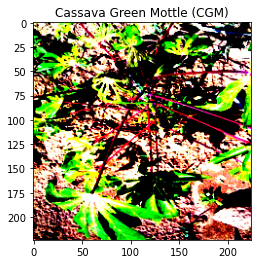

In [28]:
img, label = train_ds[0]
display_img(img, label)

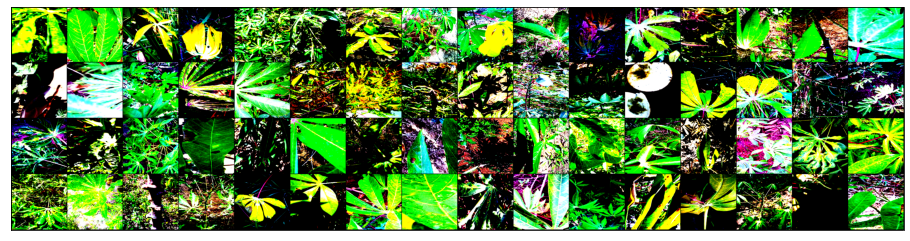

In [29]:
display_batch(next(iter(train_loader)))

# Helper Functions

In [30]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

In [31]:
def save_checkpoint(model, is_best, filename='./checkpoint.pth'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [32]:
def load_checkpoint(model, filename = './checkpoint.pth'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

In [33]:
def prec_recall_fscore(input, targs):
    scores = precision_recall_fscore_support(targs.cpu(), input.cpu(), average='macro')
    return {'precision': scores[0], 'recall': scores[1], 'fscore': scores[2], 'support': scores[3]} # return dictionary of 4 values

def print_prec_recall_fscore(scores):
    print("Precision Recall FScores Metric:")
    print(scores)
    
    return scores

# Train and Test

In [34]:
def train(loader, model, optimizer, device):
    model.train()
    correct, trn_loss, trn_time = 0., 0., 0
    t = tqdm(loader, leave=False, total=len(loader))
    bt_start = time.time()
    for i, (ip, target) in enumerate(t):
        ip, target = ip.to(device), target.to(device)                          
        output = model(ip)
        loss = criterion(output, target)
        trn_loss += loss.item()
        
        # measure accuracy and record loss
        _, pred = output.max(dim=1)
        correct += torch.sum(pred == target.data)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    trn_time = time.time() - bt_start
    trn_acc = correct * 100 / len(loader.dataset)
    trn_loss /= len(loader)
    print_prec_recall_fscore(prec_recall_fscore(pred, target))
    return trn_acc, trn_loss, trn_time

In [35]:
def valid(loader, model, optimizer, device):
    model.eval()
    with torch.no_grad():
        correct, val_loss, val_time = 0., 0., 0
        t = tqdm(loader, leave=False, total=len(loader))
        bt_start = time.time()
        for i, (ip, target) in enumerate(t):
            ip, target = ip.to(device), target.to(device)                          
            output = model(ip)
            loss = criterion(output, target)
            val_loss += loss.item()

            # measure accuracy and record loss
            _, pred = output.max(dim=1)
            correct += torch.sum(pred == target.data)

        val_time = time.time() - bt_start
        val_acc = correct * 100 / len(loader.dataset)
        val_loss /= len(loader)
        print_prec_recall_fscore(prec_recall_fscore(pred, target))
        return val_acc, val_loss, val_time

In [36]:
def fit(model, sched, optimizer, device, epoch):
    print("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
    best_acc = 0.
    for j in range(epoch):
        trn_acc, trn_loss, trn_time = train(train_loader, model, optimizer, device)
        trn_stat.append(trn_loss, trn_acc, trn_time)
        val_acc, val_loss, val_time = valid(valid_loader, model, optimizer, device)
        val_stat.append(val_acc, val_loss, val_time)
        if sched:
            sched.step()
        if val_acc > best_acc:
            best_acc = val_acc
            save_checkpoint(model, True, './best_model.pth')
        print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
              .format(j+1, trn_loss, val_loss, trn_acc, val_acc))

# Vision Transformer

Using implementation from https://github.com/nachiket273/Vision_transformer_pytorch.git

Using weights from pretrained-model on Imagenet-1k <br>
File is available at https://www.kaggle.com/nachiket273/visiontransformerpretrainedimagenet1kweights

pytorch tpu kernel available @ https://www.kaggle.com/nachiket273/pytorch-tpu-vision-transformer

In [37]:
!cp ../input/visiontransformerpretrainedimagenet1kweights/vit.py .
!cp ../input/visiontransformerpretrainedimagenet1kweights/vit_16_224_imagenet1000.pth .

In [38]:
from vit import ViT

In [39]:
def get_model(out_features=5):
    model = ViT(224, 16, drop_rate=0.1)
    load_checkpoint(model, './vit_16_224_imagenet1000.pth')
    model.out = nn.Linear(in_features=model.out.in_features, out_features=5)
    for param in model.parameters():
        param.require_grad = True
    return model

In [40]:
model = get_model()

In [41]:
model = model.to(device)

In [42]:
trn_stat = AvgStats()
val_stat = AvgStats()

In [43]:
criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss()

In [44]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))

In [45]:
epochs = 20

In [46]:
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-3)

In [47]:
fit(model, sched, optimizer, device, epochs)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc


Precision Recall FScores Metric:
{'precision': 0.7288311688311688, 'recall': 0.6227272727272727, 'fscore': 0.6230769230769231, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7384615384615385, 'recall': 0.7457142857142857, 'fscore': 0.7069696969696969, 'support': None}
1	1.16852699	0.93727422	52.74994659	65.25735474


Precision Recall FScores Metric:
{'precision': 0.6454545454545454, 'recall': 0.7155555555555555, 'fscore': 0.659047619047619, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7166666666666667, 'recall': 0.6797619047619048, 'fscore': 0.6824585218702867, 'support': None}
2	0.94740903	0.93870768	63.62706757	64.88970947


Precision Recall FScores Metric:
{'precision': 0.5916666666666666, 'recall': 0.5922222222222222, 'fscore': 0.5790476190476189, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7757575757575758, 'recall': 0.625, 'fscore': 0.5928571428571427, 'support': None}
3	0.86255524	0.94783734	67.73665619	66.36029816


Precision Recall FScores Metric:
{'precision': 0.7322222222222222, 'recall': 0.7688888888888888, 'fscore': 0.738095238095238, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.6277777777777778, 'recall': 0.5911111111111111, 'fscore': 0.5837362637362637, 'support': None}
4	0.82102027	0.78782427	69.18830109	71.32353210


Precision Recall FScores Metric:
{'precision': 0.5190476190476191, 'recall': 0.55, 'fscore': 0.44673796791443854, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.6594017094017094, 'recall': 0.6399999999999999, 'fscore': 0.6340350877192983, 'support': None}
5	0.78452014	0.73745689	70.47637939	72.24264526


Precision Recall FScores Metric:
{'precision': 0.7533333333333333, 'recall': 0.7611111111111111, 'fscore': 0.7361904761904762, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.6321212121212122, 'recall': 0.6261904761904762, 'fscore': 0.6000449842555106, 'support': None}
6	0.76942809	0.81547091	71.35554504	69.85294342


Precision Recall FScores Metric:
{'precision': 0.5633333333333332, 'recall': 0.6571428571428571, 'fscore': 0.5742355889724311, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7621212121212121, 'recall': 0.7444444444444445, 'fscore': 0.7114285714285714, 'support': None}
7	0.74858161	0.79658458	71.58045197	71.13970947


Precision Recall FScores Metric:
{'precision': 0.5913419913419913, 'recall': 0.5538461538461539, 'fscore': 0.5619047619047619, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8142857142857143, 'recall': 0.7983333333333333, 'fscore': 0.7909388856757278, 'support': None}
8	0.71121552	0.72748190	73.27744293	72.05882263


Precision Recall FScores Metric:
{'precision': 0.8266666666666668, 'recall': 0.7366666666666667, 'fscore': 0.7297435897435898, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.6880952380952381, 'recall': 0.6085714285714285, 'fscore': 0.5749328449328449, 'support': None}
9	0.68602760	0.79410397	74.19750214	70.22058868


Precision Recall FScores Metric:
{'precision': 0.8914285714285715, 'recall': 0.8714285714285716, 'fscore': 0.8761904761904761, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8125, 'recall': 0.6733333333333333, 'fscore': 0.6819047619047619, 'support': None}
10	0.65906447	0.80242294	75.46514130	72.05882263


Precision Recall FScores Metric:
{'precision': 0.4795238095238096, 'recall': 0.5657142857142856, 'fscore': 0.5103030303030303, 'support': None}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision Recall FScores Metric:
{'precision': 0.5693506493506493, 'recall': 0.5472727272727272, 'fscore': 0.5454106280193236, 'support': None}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11	0.65138271	0.65900492	75.97628021	75.00000000


Precision Recall FScores Metric:
{'precision': 0.6666666666666666, 'recall': 0.5736363636363636, 'fscore': 0.6092063492063492, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.6711111111111112, 'recall': 0.6773809523809524, 'fscore': 0.6113063407181054, 'support': None}
12	0.61001453	0.71492101	76.99856567	71.87500000


Precision Recall FScores Metric:
{'precision': 0.875, 'recall': 0.8433333333333334, 'fscore': 0.8453679653679653, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7771428571428571, 'recall': 0.7785714285714287, 'fscore': 0.7750915750915751, 'support': None}
13	0.59483197	0.71723504	78.24575806	74.81617737


Precision Recall FScores Metric:
{'precision': 0.7047619047619047, 'recall': 0.7064285714285714, 'fscore': 0.7035497835497836, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8964285714285714, 'recall': 0.875, 'fscore': 0.881043956043956, 'support': None}
14	0.55779432	0.70075775	78.90001678	73.52941132


Precision Recall FScores Metric:
{'precision': 0.8457142857142858, 'recall': 0.8266666666666668, 'fscore': 0.8133333333333332, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7259523809523809, 'recall': 0.7628571428571429, 'fscore': 0.723076923076923, 'support': None}
15	0.52787606	0.82452473	80.65834808	72.97794342


Precision Recall FScores Metric:
{'precision': 0.8266666666666668, 'recall': 0.82, 'fscore': 0.8092063492063492, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8, 'recall': 0.7222222222222222, 'fscore': 0.7297058823529412, 'support': None}
16	0.51905841	0.85451153	81.00592804	70.40441132


Precision Recall FScores Metric:
{'precision': 0.7266666666666667, 'recall': 0.6599999999999999, 'fscore': 0.6788311688311689, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8166666666666667, 'recall': 0.7228571428571429, 'fscore': 0.696969696969697, 'support': None}
17	0.51521270	0.82931999	81.02637482	70.77205658


Precision Recall FScores Metric:
{'precision': 0.7533333333333333, 'recall': 0.7742857142857142, 'fscore': 0.7456709956709956, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.65, 'recall': 0.5833333333333333, 'fscore': 0.5390909090909091, 'support': None}
18	0.49590947	0.80824373	81.82375336	73.34558868


Precision Recall FScores Metric:
{'precision': 0.8714285714285716, 'recall': 0.8964285714285716, 'fscore': 0.8606593406593406, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7230952380952381, 'recall': 0.7261904761904762, 'fscore': 0.7154545454545455, 'support': None}
19	0.48177884	0.78030904	81.98731995	73.89705658


Precision Recall FScores Metric:
{'precision': 0.8857142857142858, 'recall': 0.8928571428571429, 'fscore': 0.8681651681651681, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7883333333333333, 'recall': 0.8134615384615385, 'fscore': 0.7915217391304348, 'support': None}
20	0.45224357	0.84162862	83.80699158	72.05882263


# Predict

In [48]:
test_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [49]:
load_checkpoint(model, './best_model.pth')

In [50]:
def predict(test_dir, model, device):
    img_names = []
    preds = []
    for name in os.listdir(test_dir):
        img_path = os.path.join(test_dir, name)
        img = Image.open(img_path).convert("RGB")
        img = test_tf(img)
        img = img.unsqueeze(0)
        img = img.to(device)
        op = model(img)
        _, pred = op.max(dim=1)
        img_names.append(name)
        preds.append(pred.item())
    return img_names, preds

In [51]:
img_names, preds = predict(test_dir, model, device)

In [52]:
img_names, preds

(['2216849948.jpg'], [3])

In [53]:
# sub_df.head()

In [54]:
# sub_df['image_id'] = img_names
# sub_df['label'] = preds

In [55]:
# sub_df.head()

In [56]:
# sub_df.to_csv('submission.csv', index=False)